# Multivariate time series forecasting using 1D convolution  
**Authors:** Konrad Maciejczyk (276927), Robert Walery (249000), Katarzyna Czak (254752)  
Wrocław University of Science and Technology, 2023-2024  

**Dataset:** [Stock Exchange Data](https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning)  

In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data loading and preprocessing

In [49]:
stock_df = pd.read_csv('indexData.csv')
stock_NYA_df = stock_df[stock_df['Index'] == 'NYA'].dropna()
dates = stock_NYA_df['Date']
stock_NYA_df.drop(['Index', 'Date', 'Volume'], axis='columns', inplace=True)
stock_NYA_df

,Open,High,Low,Close,Adj Close
0,528.690002,528.690002,528.690002,528.690002,528.690002
1,527.210022,527.210022,527.210022,527.210022,527.210022
2,527.840027,527.840027,527.840027,527.840027,527.840027
3,531.119995,531.119995,531.119995,531.119995,531.119995
4,532.070007,532.070007,532.070007,532.070007,532.070007
...,...,...,...,...,...
13943,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450
13944,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450
13945,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940
13946,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220


In [50]:
stock_NYA_df = stock_NYA_df['Adj Close']
stock_NYA_df = np.reshape(stock_NYA_df, (len(stock_NYA_df), 1))
scaler = MinMaxScaler()
stock_NYA_df = scaler.fit_transform(stock_NYA_df)


In [51]:
WINDOW_SIZE = 10
#FEATURE_SIZE = stock_NYA_df.shape[1]
FEATURE_SIZE = 1

def df_to_X_y(df, window_size = 6):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [52]:
X, y = df_to_X_y(stock_NYA_df, window_size = WINDOW_SIZE)
X.shape, y.shape

((13937, 10, 1), (13937, 1))

## Splitting data into training, validating and testing datasets

In [53]:
train_len = int(stock_NYA_df.shape[0] * 0.8)
test_val_len = int(stock_NYA_df.shape[0] * 0.1)

X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len: train_len + test_val_len], y[train_len: train_len + test_val_len]
X_test, y_test = X[train_len + test_val_len: train_len + (test_val_len * 2)], y[train_len + test_val_len: train_len + (test_val_len * 2)]

print(f'Training dataset size: {X_train.shape}')
print(f'Testing dataset size: {X_test.shape}')
print(f'Validation dataset size: {X_val.shape}')

Training dataset size: (11157, 10, 1)
Testing dataset size: (1386, 10, 1)
Validation dataset size: (1394, 10, 1)


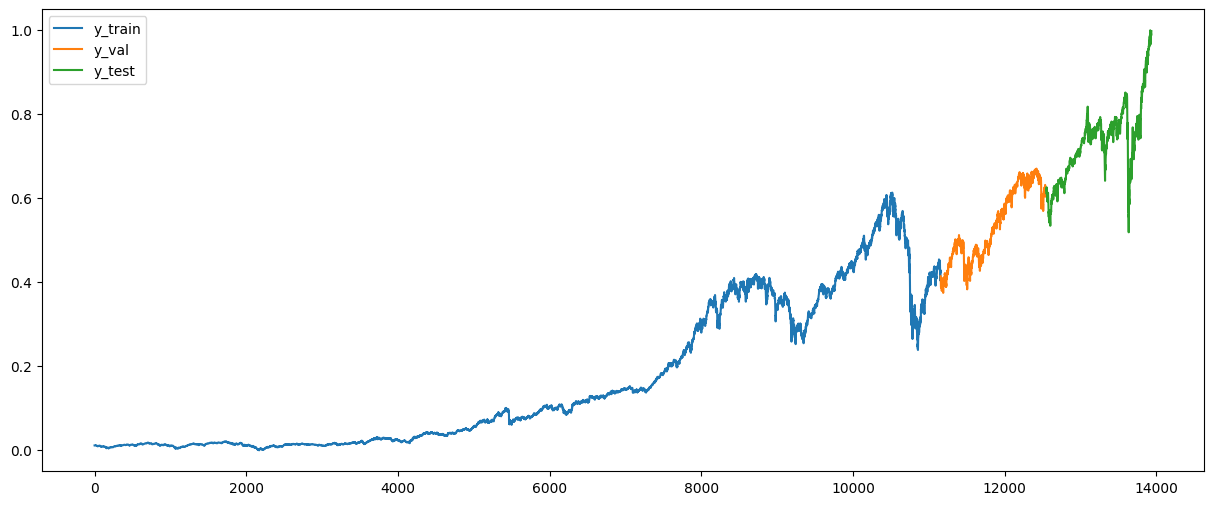

In [54]:
plt.figure(figsize=(15, 6))
a = y_train.shape[0]
plt.plot([_ for _ in range(a)], y_train, label = 'y_train')
a, b= y_train.shape[0], y_train.shape[0] + y_val.shape[0]
plt.plot([_ for _ in range(a, b)], y_val, label = 'y_val')
a, b = y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]
plt.plot([_ for _ in range(a, b)], y_test, label = 'y_test')
plt.legend()
plt.show()

## Model architecture  

In [55]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((WINDOW_SIZE, FEATURE_SIZE)))
model.add(tf.keras.layers.Conv1D(64, kernel_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, 'relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 9, 64)             │        192 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_3 (Flatten)             │ (None, 576)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 8)                 │      4,616 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,817 (18.82 KB)

 Trainable params: 4,817 (18.82 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

In [57]:
EPOCHS = 30
BATCH_SIZE = 128

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - mae: 0.0444 - val_loss: 8.2338e-05 - val_mae: 0.0068
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3724e-05 - mae: 0.0026 - val_loss: 8.1550e-05 - val_mae: 0.0068
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3077e-05 - mae: 0.0025 - val_loss: 8.1162e-05 - val_mae: 0.0069
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2610e-05 - mae: 0.0025 - val_loss: 7.9708e-05 - val_mae: 0.0067
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0873e-05 - mae: 0.0024 - val_loss: 8.1883e-05 - val_mae: 0.0067
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2888e-05 - mae: 0.0024 - val_loss: 7.8507e-05 - val_mae: 0.0066
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1837e-05 - mae: 0.0025 - val_loss: 7.9863e-05 - val_mae: 0.0066
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0716e-05 - mae: 0.0025 - val_loss: 7.9002e-05 - val_mae: 0.0070
Epoch 9/30
8

## Model evaluation

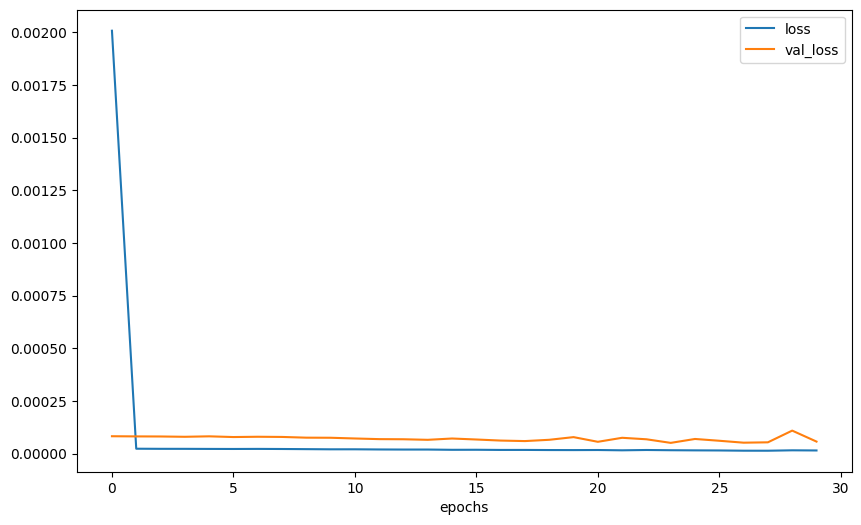

In [58]:
plt.figure(figsize=(10, 6))
plt.plot([_ for _ in range(EPOCHS)], history.history['loss'], label = 'loss')
plt.plot([_ for _ in range(EPOCHS)], history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

### Predicting on test data 

In [59]:
pred = model.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

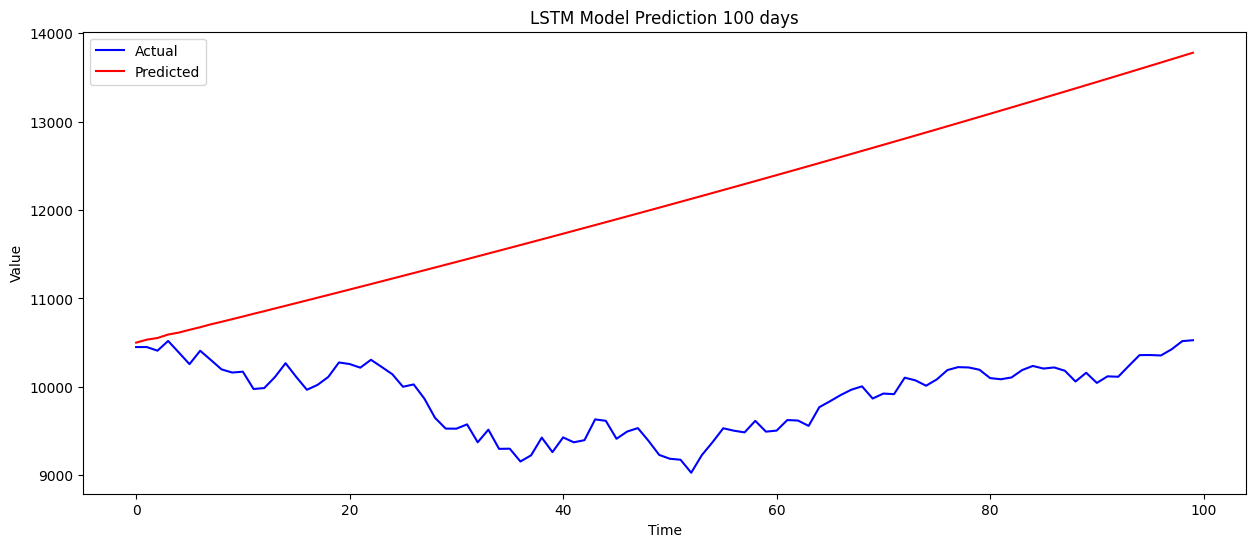

In [60]:
predictions = []
num_predictions = 100

current_window = X_test[0].reshape(1, -1, 1)

for i in range(num_predictions):
    predict_val = model.predict(current_window)
    predictions.append(predict_val[0, 0])
    current_window = np.concatenate((current_window[:, 1:, :], predict_val.reshape(1, 1, 1)), axis=1)

y_test_actual = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
predictions_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:num_predictions], label='Actual', color='blue')
plt.plot(predictions_actual, label='Predicted', color='red')
plt.title('LSTM Model Prediction 100 days')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [61]:
print('Mean absolute error (predictions - actuals): {:.3f}'.format(mean_absolute_error(y_test, pred)))

Mean absolute error (predictions - actuals): 0.007
